In [166]:
import utils
from typing import List, Set
from tqdm.auto import tqdm, trange
import re
import numpy as np

from collections import defaultdict, deque
from dataclasses import dataclass, field

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import pandas as pd

# Day 12 The N-Body Problem

We have planets in orbit, which have a 3 axis position and velocity, need to simulate their movements.

I'm parsing the input as both a list of Planets and a numpy array - planets is easier to deal with, but the numpy array is faster.

In [169]:
A = """<x=-1, y=0, z=2>
<x=2, y=-10, z=-7>
<x=4, y=-8, z=8>
<x=3, y=5, z=-1>"""

@dataclass
class Planet:
    x  :int = None
    y  :int = None
    z  :int = None
    vx :int = 0 
    vy: int = 0
    vz: int = 0

def parse_input(inp=None, day=12):
    """parses input to both a list of planets and a numpy array"""
    if inp == None:
        inp = utils.get_input(day)
    inp = inp.strip().splitlines()
    
    data = []
    dat = []
    
    for entry in inp:
        x, y, z = [int(i) for i in re.findall("-?[\d]+", entry)]
        data.append(Planet(x, y, z))
        dat.append([x, y, z, 0, 0, 0])
    return data, np.array(dat)

inp, dat = parse_input(A)
inp, dat

([Planet(x=-1, y=0, z=2, vx=0, vy=0, vz=0),
  Planet(x=2, y=-10, z=-7, vx=0, vy=0, vz=0),
  Planet(x=4, y=-8, z=8, vx=0, vy=0, vz=0),
  Planet(x=3, y=5, z=-1, vx=0, vy=0, vz=0)],
 array([[ -1,   0,   2,   0,   0,   0],
        [  2, -10,  -7,   0,   0,   0],
        [  4,  -8,   8,   0,   0,   0],
        [  3,   5,  -1,   0,   0,   0]]))

In [170]:
inp, dat = parse_input(inp=A)

def get_deltas(arr):
    deltas = np.empty_like(arr)
    for i, val in enumerate(arr):
        relative_pos = arr - val
        vel = np.sum(relative_pos > 0) - np.sum(relative_pos < 0)
        deltas[i] = vel
        
    return deltas

def update(dat, times=1):
    for _ in range(times):
        deltas = np.apply_along_axis(get_deltas, 0, dat[:,:3])
        # update velocity
        dat[:,3:] += deltas
        # now update position
        dat[:,:3] += dat[:,3:]
    return dat
    
update(dat, 1)

array([[ 2, -1,  1,  3, -1, -1],
       [ 3, -7, -4,  1,  3,  3],
       [ 1, -7,  5, -3,  1, -3],
       [ 2,  2,  0, -1, -3,  1]])

In [171]:
def energy(data):
    potential_energy = np.abs(data[:,:3]).sum(axis=1)
    kinetic_energy = np.abs(data[:,3:]).sum(axis=1)
    total_energy = sum(potential_energy * kinetic_energy)
    return total_energy

def solve_1(inp=None, steps=12):
    inp, dat = parse_input(inp)
    
    dat = update(dat, 1000)    
    return energy(dat)
    
solve_1()

7077

Part 1: `7077`

## Part 2

When do the planets arrive back at a previous state?

Here the main assumption is that the first duplicate state will be the initial state. 

The below is pretty inefficent code, but it gets the right answer so leaving it for now.


In [236]:
def solve_2(inp=None):
    
    # stores the period for each xyx pos to cycle back to initial
    periods = np.zeros(3, dtype="int64")

    for col in tqdm([0, 1, 2], desc="Processing positions xyz ones at a time"):

        _, dat = parse_input(inp) # only using the numpy repr
        initial_state = dat.copy() # fix this func so it only updates one col 
        dat = update(dat, 1)
        period = 1

        while True:
            same = np.all(dat[:, [col, col+3]] == initial_state[:, [col, col+3]])
            if not same:
                dat = update(dat, 1)
                period += 1
            else: 
                periods[col] = period
                print(f"Exiting col {col}, periods at {periods}")
                break
                
    return np.lcm.reduce(periods)

solve_2()

Exiting col 0, periods at [231614      0      0]
Exiting col 1, periods at [231614  96236      0]
Exiting col 2, periods at [231614  96236 144624]



402951477454512

`402951477454512` for part 2

In [234]:
# non numpy way to do this
from math import gcd 
from functools import reduce

def lcm(denominators):
    return reduce(lambda a,b: a*b // gcd(a,b), denominators)

lcm(periods)

402951477454512

## Viz

In [140]:
df = pd.DataFrame(dat, columns=["x", "y", "z", "xv", "yv", "zv"])
df["time"] = 0
df["names"]= ["Io", "Europa", "Ganymede", "Callisto"]
df

,x,y,z,xv,yv,zv,time,names
0,2,-1,1,3,-1,-1,0,Io
1,3,-7,-4,1,3,3,0,Europa
2,1,-7,5,-3,1,-3,0,Ganymede
3,2,2,0,-1,-3,1,0,Callisto


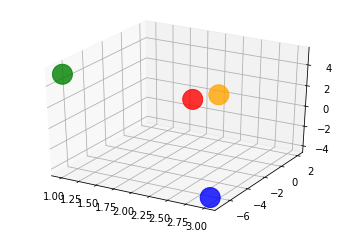

In [167]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = ["red", "blue", "green", "orange"]
ax.scatter(df.x, df.y, df.z, s=400, c=colors, alpha=0.8);

In [172]:
px.scatter_3d(df, "x", "y", "z")